<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-ICA-from-spkit" data-toc-modified-id="Import-ICA-from-spkit-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import ICA from spkit</a></span></li><li><span><a href="#Load-sample-EEG-Data-(-16-sec,-128-smapling-rate,-14-channel)" data-toc-modified-id="Load-sample-EEG-Data-(-16-sec,-128-smapling-rate,-14-channel)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load sample EEG Data ( 16 sec, 128 smapling rate, 14 channel)</a></span><ul class="toc-item"><li><span><a href="#Filter-signal-(with-IIR-highpass-1Hz)" data-toc-modified-id="Filter-signal-(with-IIR-highpass-1Hz)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Filter signal (with IIR highpass 1Hz)</a></span></li></ul></li><li><span><a href="#Apply-ICA-on-2-sec-segment-of-EEG" data-toc-modified-id="Apply-ICA-on-2-sec-segment-of-EEG-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Apply ICA on 2 sec segment of EEG</a></span></li><li><span><a href="#Decomposition-and-Construction-matrices-(Extended-InfoMax)" data-toc-modified-id="Decomposition-and-Construction-matrices-(Extended-InfoMax)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Decomposition and Construction matrices (Extended InfoMax)</a></span></li></ul></div>

# Independed Principle Component analysis with 
# *InfoMax, Extended InfoMax, FastICA, & Picard*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import signal
from joblib import Parallel, delayed

## Import ICA from spkit

In [11]:
from spkit import ICA
from spkit.data import load_data

## Load sample EEG Data ( 16 sec, 128 smapling rate, 14 channel)
### Filter signal (with IIR highpass 1Hz)

In [3]:
X,ch_names = load_data.eegSample()

In [4]:
band =[1,63.5]
order,fs = 5,128
b,a = signal.butter(order,np.array(band)/(0.5*fs),btype='bandpass')
Xf = np.array(Parallel(n_jobs=-1)(delayed(signal.lfilter)(b,a,X[:,i]) for i in range(X.shape[1]))).T

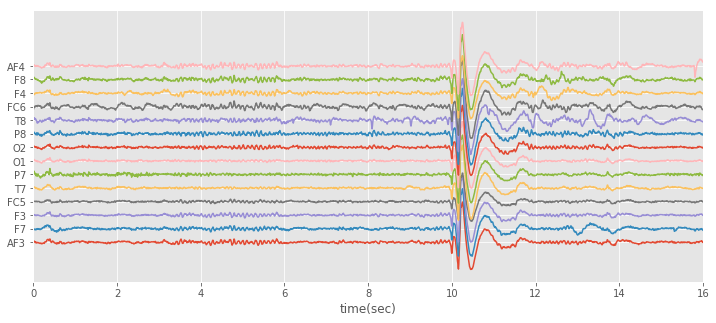

In [5]:
t = np.arange(X.shape[0])/128.0
plt.figure(figsize=(12,5))
plt.plot(t,Xf+np.arange(-7,7)*200)
plt.xlim([t[0],t[-1]])
plt.xlabel('time(sec)')
plt.yticks(np.arange(-7,7)*200,ch_names)
plt.show()

## Apply ICA on 2 sec segment of EEG

In [12]:
methods = ('fastica', 'infomax', 'extended-infomax', 'picard')
icap = ['ICA'+str(i) for i in range(1,15)]

 
Computing Extended Infomax ICA


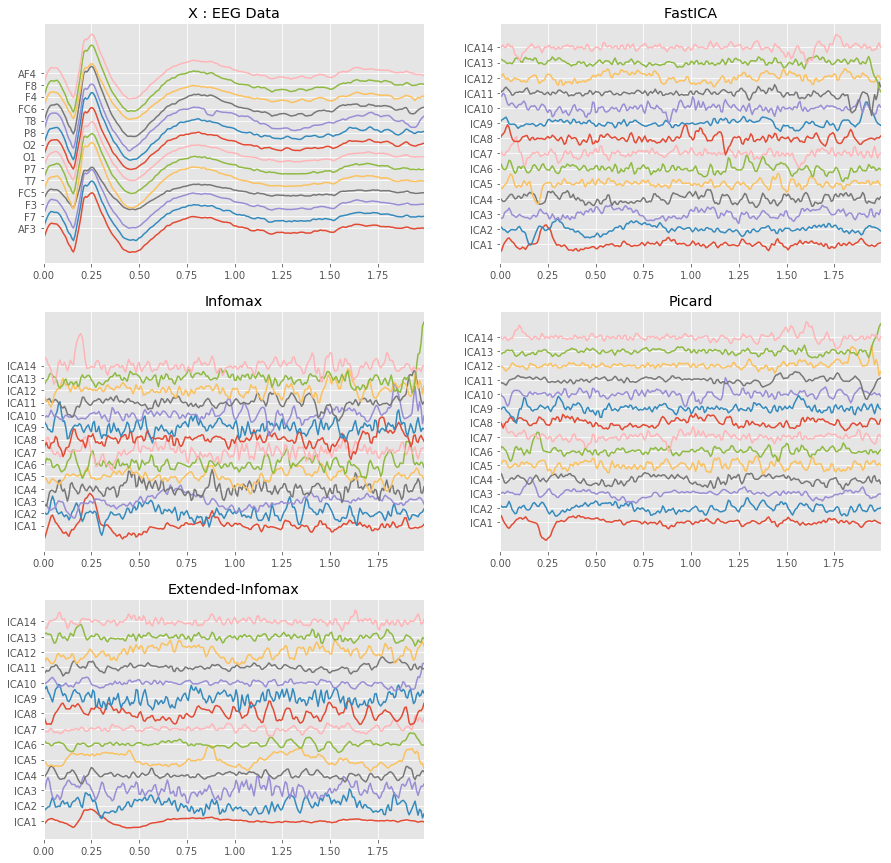

In [13]:
x = Xf[128*10:128*12,:]
t = np.arange(x.shape[0])/128.0

myICA = ICA(n_components=14,method='fastica')
myICA.fit(x.T)
s1 = myICA.transform(x.T)

myICA = ICA(n_components=14,method='infomax')
myICA.fit(x.T)
s2 = myICA.transform(x.T)

myICA = ICA(n_components=14,method='picard')
myICA.fit(x.T)
s3 = myICA.transform(x.T)

myICA = ICA(n_components=14,method='extended-infomax')
myICA.fit(x.T)
s4 = myICA.transform(x.T)


plt.figure(figsize=(15,15))
plt.subplot(321)
plt.plot(t,x+np.arange(-7,7)*200)
plt.xlim([t[0],t[-1]])
plt.yticks(np.arange(-7,7)*200,ch_names)
plt.title('X : EEG Data')

plt.subplot(322)
plt.plot(t,s1.T+np.arange(-7,7)*700)
plt.xlim([t[0],t[-1]])
plt.yticks(np.arange(-7,7)*700,icap)
plt.title('FastICA')

plt.subplot(323)
plt.plot(t,s2.T+np.arange(-7,7)*700)
plt.xlim([t[0],t[-1]])
plt.yticks(np.arange(-7,7)*700,icap)
plt.title('Infomax')

plt.subplot(324)
plt.plot(t,s3.T+np.arange(-7,7)*700)
plt.xlim([t[0],t[-1]])
plt.yticks(np.arange(-7,7)*700,icap)
plt.title('Picard')

plt.subplot(325)
plt.plot(t,s4.T+np.arange(-7,7)*700)
plt.xlim([t[0],t[-1]])
plt.yticks(np.arange(-7,7)*700,icap)
plt.title('Extended-Infomax')
plt.show()

## Decomposition and Construction matrices (Extended InfoMax)

$$ S = A\cdot (X-\mu)$$
$$ X = W\cdot S + \mu$$
where $\mu$ is mean, computed before applying PCA

In [9]:
mu = myICA.pca_mean_[:, None]
W = myICA.get_sMatrix()
A = myICA.get_tMatrix()

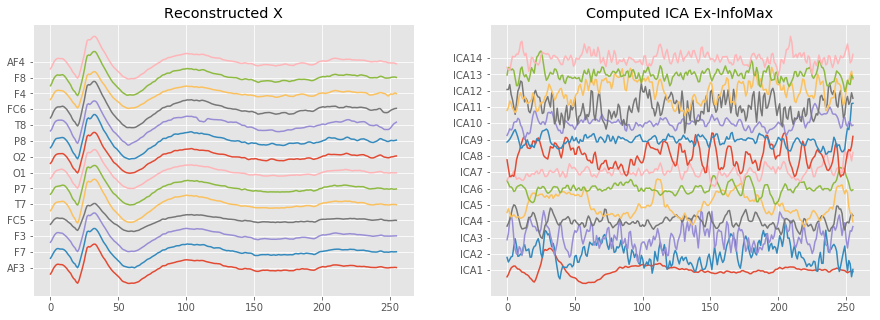

Error X 8.51877856450356e-12
Error S -2.443648061678516e-11


In [10]:
s1 = np.dot(A,(x.T-mu))
x1 = np.dot(W,s4)+mu

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(x1.T+np.arange(-7,7)*400)
plt.yticks(np.arange(-7,7)*400,ch_names)
plt.title('Reconstructed X')
plt.subplot(122)
plt.plot(s1.T+np.arange(-7,7)*400)
plt.title('Computed ICA Ex-InfoMax')
plt.yticks(np.arange(-7,7)*400,icap)
plt.show()
print('Error X',np.sum(x1-x.T))
print('Error S',np.sum(s1-s4))